# Flavor Transformation Tests

Load a supernova model and plot the effects of flavor transformations on the neutrino spectra at a particular time.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from astropy import units as u 

from snewpy.neutrino import Flavor, MassHierarchy
from snewpy.models import Nakazato_2013
from snewpy.flavor_transformation import NoTransformation, \
                                         AdiabaticMSW, NonAdiabaticMSWH, \
                                         TwoFlavorDecoherence, ThreeFlavorDecoherence, \
                                         NeutrinoDecay, AdiabaticMSWes, NonAdiabaticMSWes

In [2]:
mpl.rc('font', size=18)

### Model: Nakazato 2013

Load a Nakazato model.

In [3]:
ifile = '../../models/Nakazato_2013/nakazato-shen-z0.004-t_rev100ms-s20.0.fits'
model = Nakazato_2013(ifile)

In [4]:
model

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:---------|:-----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|Metallicity | $0.004$|
|Revival time | $100$ $\mathrm{ms}$|
|EOS | SHEN|

## Flavor Transformations

Apply a set of flavor transformations at an early time in the explosion.

In [5]:
def plot_lum(model, flav_xform, E=np.linspace(0,100,201)*u.MeV, check_imo=False, to_flux=False):
    """Plot initial and oscillated neutrino spectra.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    t : astropy.Quantity
        Time to compute the spectrum.
    E : ndarray
        List of energies to compute the spectrum.
    check_imo : bool
        Check the effect of inverting the neutrino mass hierarchy.
    """
    if check_imo:
        xform_nmo = flav_xform(mh=MassHierarchy.NORMAL)
        xform_imo = flav_xform(mh=MassHierarchy.INVERTED)
    else:
        xform_nmo = flav_xform()
        xform_imo = xform_nmo
    
    times = model.get_time()
    burst = times <= 0.1*u.s
    accr = (times > 0.1*u.s) & (times <= 0.5*u.s)
    cool = (times > 0.5*u.s) & (times <= 10*u.s)
    
    ilum = {}
    olum_nmo = {}
    olum_imo = {}
    
    for flavor in Flavor:
        ilum[flavor] = np.zeros(len(times))
        olum_nmo[flavor] = np.zeros(len(times))
        olum_imo[flavor] = np.zeros(len(times))

    # Compute the initial and oscillated spectra at each time.
    for i, t in enumerate(times):
        ispec = model.get_initialspectra(t, E)
        ospec_nmo = model.get_oscillatedspectra(t, E, xform_nmo)
        ospec_imo = model.get_oscillatedspectra(t, E, xform_imo)
        
        for flavor in Flavor:
            ilum[flavor][i] = np.trapz(ispec[flavor].to('1/(erg*s)'), E.to('erg')).value
            olum_nmo[flavor][i] = np.trapz(ospec_nmo[flavor].to('1/(erg*s)'), E.to('erg')).value
            olum_imo[flavor][i] = np.trapz(ospec_imo[flavor].to('1/(erg*s)'), E.to('erg')).value

    fig, axes = plt.subplots(3,3, figsize=(20,12), tight_layout=True)
    
    smax = [0.,0.,0.]
    titles = ['Unoscillated', 'Transformed (NMO)', 'Transformed (IMO)']
    for i, spec in enumerate([ilum, olum_nmo, olum_imo]):
        for j, phase in enumerate([burst, accr, cool]):
            ax = axes[i,j]
            timeunits = 'ms' if j==0 else 's'
                
            for flavor in Flavor:
                if to_flux:
                    d = (10*u.kpc).to('cm').value
                    spec[flavor][phase] /= d**2
                
                if i == 0:
                    smax[j] = np.maximum(smax[j], 1.1*np.max(spec[flavor][phase]))
                    
                ax.plot(times[phase].to(timeunits),
                        spec[flavor][phase], label=flavor.to_tex(), lw=3,
                        color='C0' if flavor.is_electron else 'C1',
                        ls='-' if flavor.is_neutrino else ':')
            
            ax.set(xlim=(times[phase][0].to(timeunits).value, times[phase][-1].to(timeunits).value),
                   ylim=(0, smax[j]))
            
            if j==0:
                if to_flux:
                    ax.set(ylabel='flux [cm$^{-2}$ s$^{-1}$]')
                else:
                    ax.set(ylabel='luminosity [s$^{-1}$]')
                ax.legend(loc='upper right', ncol=1, fontsize=16)
            if j==1:
                ax.set(title=titles[i])
            if i < 2:
                ax.set(xticklabels=[])
            else:
                ax.set(xlabel='time [{}]'.format(timeunits))
            
            ax.grid(ls=':')

    return fig


def plot_spec(model, flav_xform, t=50*u.ms, E=np.linspace(0,100,201)*u.MeV, check_imo=False):
    """Plot initial and oscillated neutrino spectra.
    
    Parameters
    ----------
    model : SupernovaModel
        An input model from a CCSN simulation.
    flav_xform : FlavorTransformation
        A FlavorTransformation subclass; used to create an instance.
    t : astropy.Quantity
        Time to compute the spectrum.
    E : ndarray
        List of energies to compute the spectrum.
    check_imo : bool
        Check the effect of inverting the neutrino mass hierarchy.
    """
    if check_imo:
        xform_nmo = flav_xform(mh=MassHierarchy.NORMAL)
        xform_imo = flav_xform(mh=MassHierarchy.INVERTED)
    else:
        xform_nmo = flav_xform()
        xform_imo = xform_nmo
        
    # Compute the initial and oscillated spectra.
    ispec = model.get_initialspectra(t, E)
    ospec_nmo = model.get_oscillatedspectra(t, E, xform_nmo)
    ospec_imo = model.get_oscillatedspectra(t, E, xform_imo)

    # Plot the spectra.
    fig, axes = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=True, tight_layout=True)

    mh = ['NMO', 'IMO']

    for i, spec in enumerate([ispec, ospec_nmo, ospec_imo]):
        ax = axes[i]
        for flavor in Flavor:
            ax.plot(E, spec[flavor],
                    label=flavor.to_tex(),
                    color='C0' if flavor.is_electron else 'C1',
                    ls='-' if flavor.is_neutrino else ':', lw=3,
                    alpha=0.7)

        ax.set(xlabel=r'$E$ [{}]'.format(E.unit),
               title='Initial Spectra: $t = ${:.1f}'.format(t) if i==0 else 'Oscillated Spectra: {}'.format(mh[i-1]))
        ax.grid()
        ax.legend(loc='upper right', ncol=2, fontsize=16)

    ax = axes[0]
    ax.set(ylabel=r'flux [erg$^{-1}$ s$^{-1}$]')

    fig.tight_layout()
    return fig

### `NoTransformation`

#### Luminosity

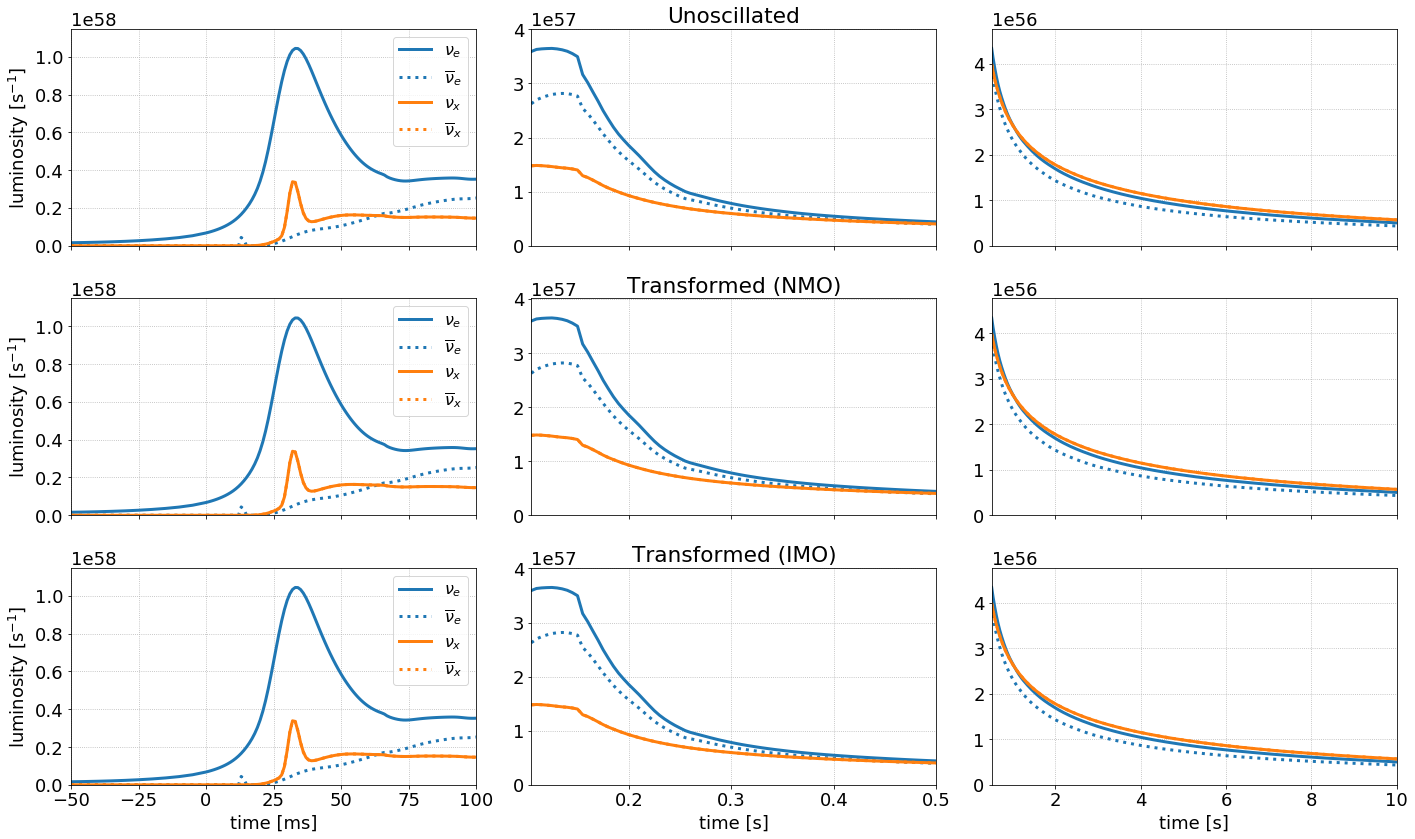

In [6]:
fig = plot_lum(model, NoTransformation)
fig.savefig('lum_notransformation.pdf')

#### Flux

Convert to flux, assuming the progenitor distance is 10 kpc from Earth.

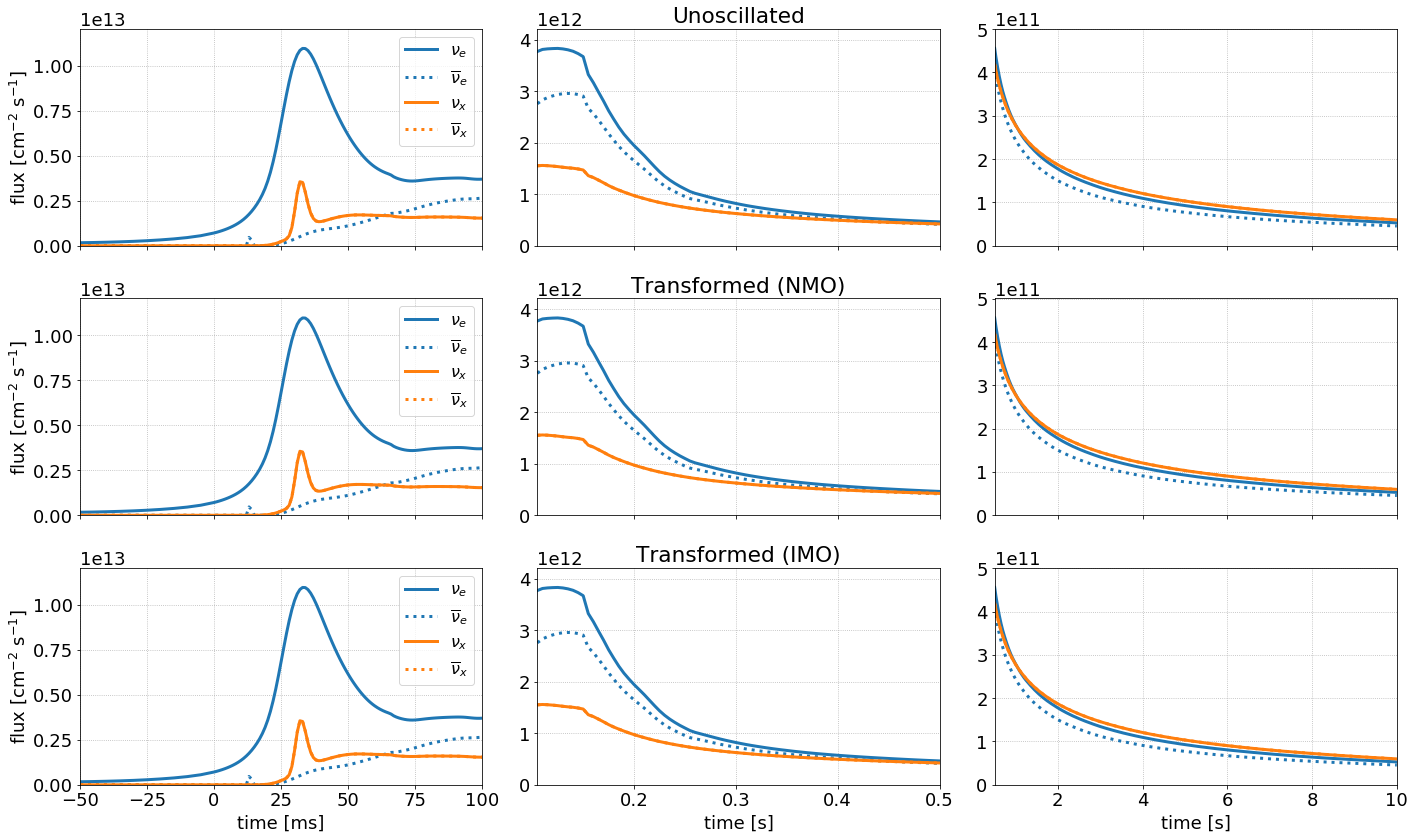

In [7]:
fig = plot_lum(model, NoTransformation, to_flux=True)
fig.savefig('flux_notransformation.pdf')

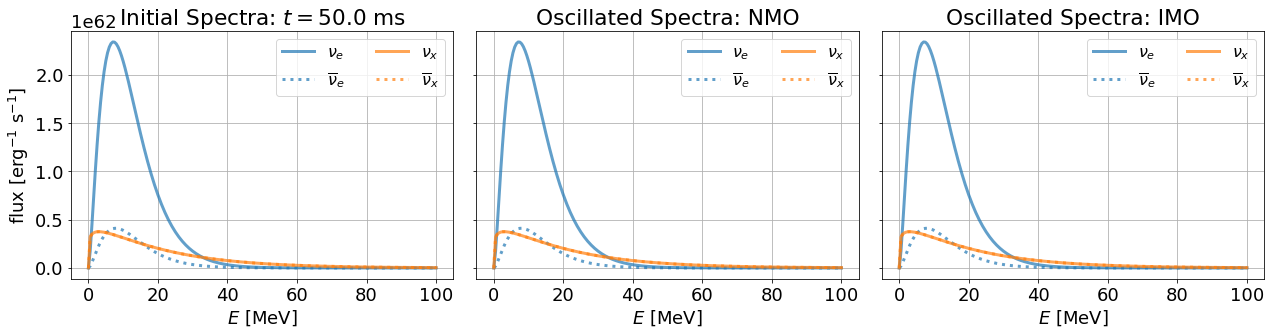

In [8]:
fig = plot_spec(model, NoTransformation)

### `AdiabaticMSW`

#### Luminosity

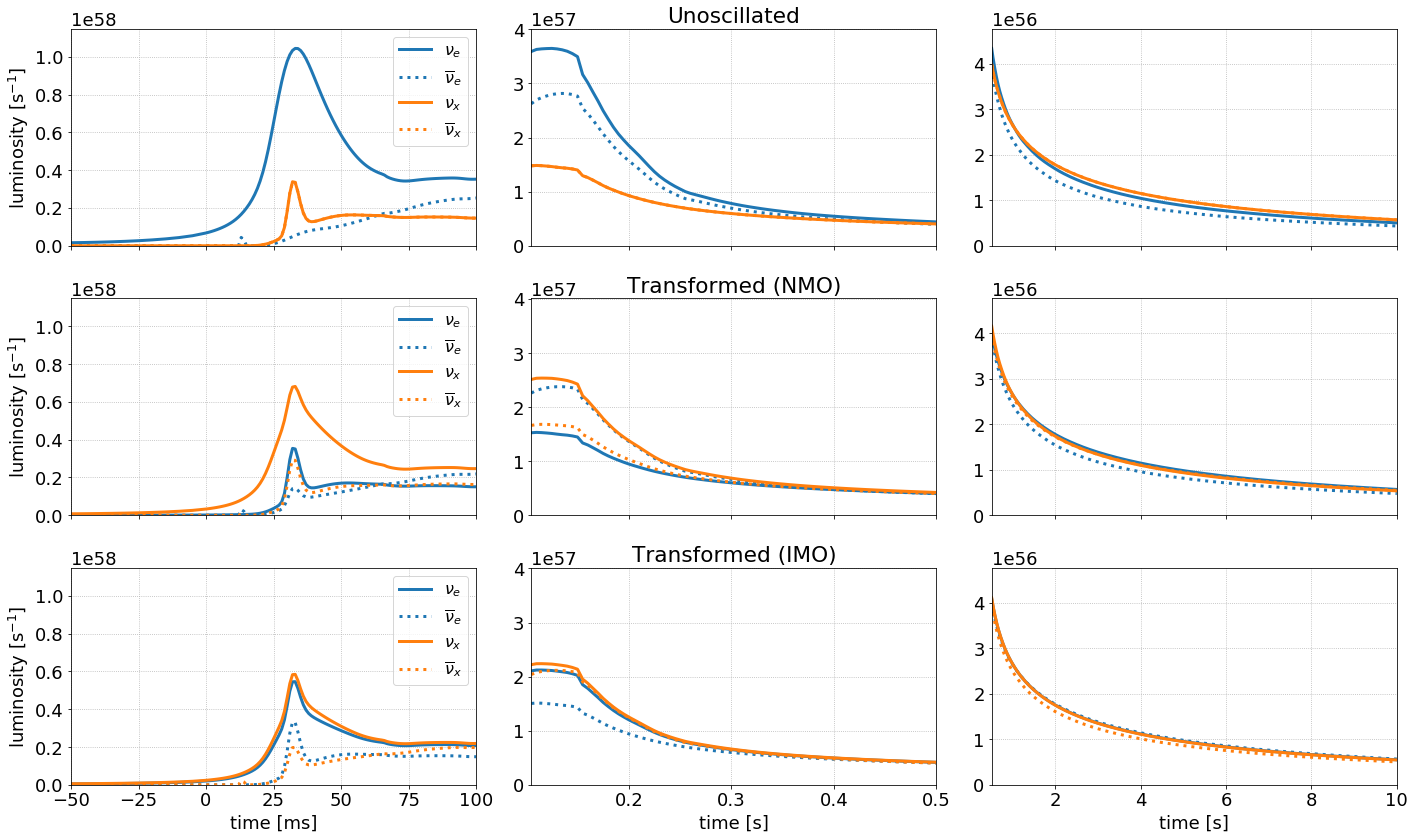

In [9]:
fig = plot_lum(model, AdiabaticMSW, check_imo=True)
fig.savefig('lum_adiabaticmsw.pdf')

#### Flux

Convert to flux at Earth, assuming the progenitor distance is 10 kpc.

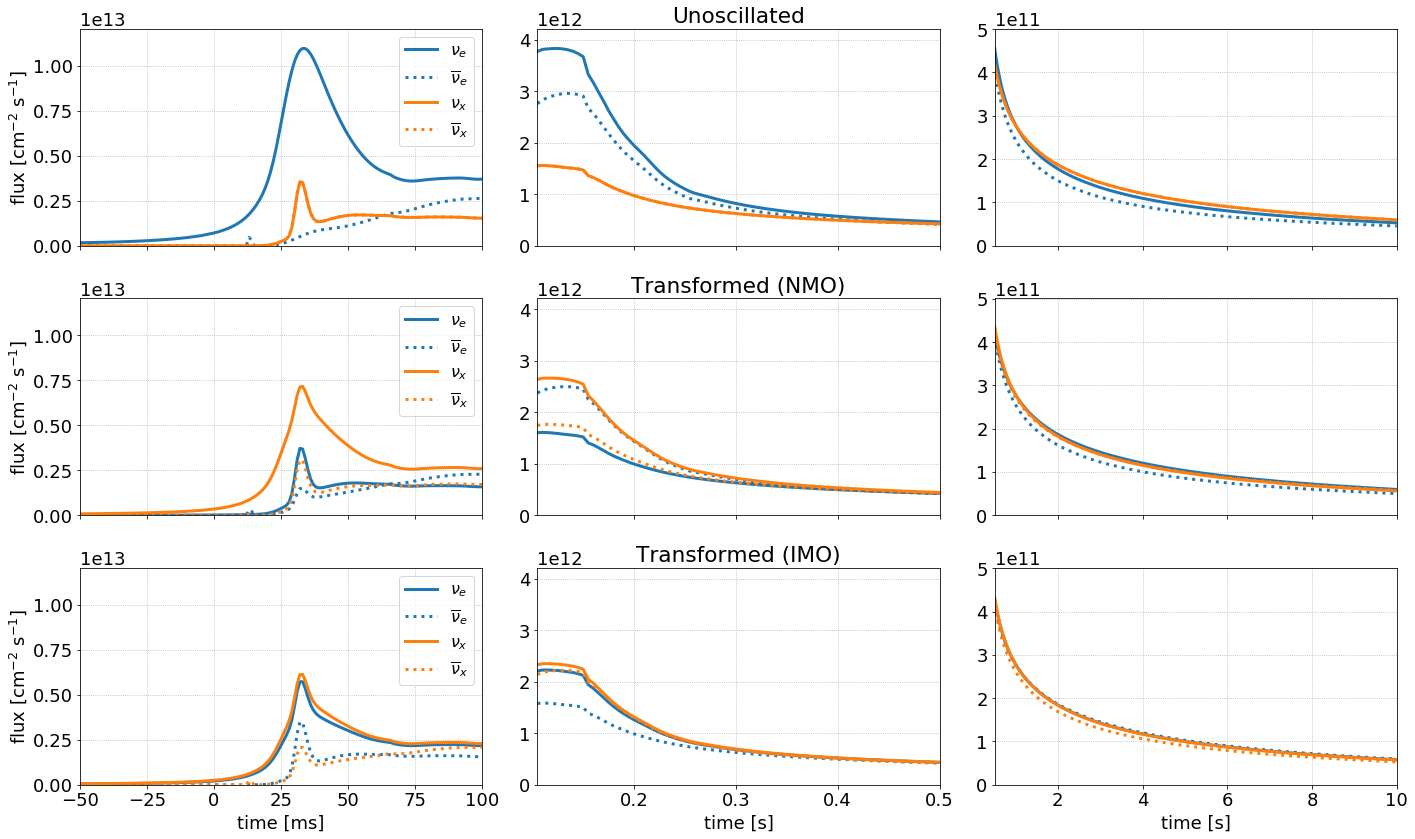

In [10]:
fig = plot_lum(model, AdiabaticMSW, check_imo=True, to_flux=True)
fig.savefig('flux_adiabaticmsw.pdf')

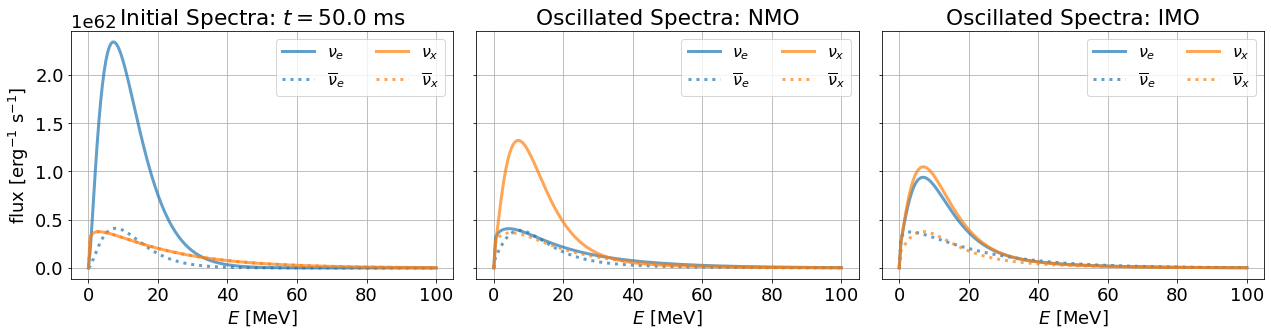

In [11]:
fig = plot_spec(model, AdiabaticMSW, check_imo=True)

### `NonAdiabaticMSWH`

#### Luminosity

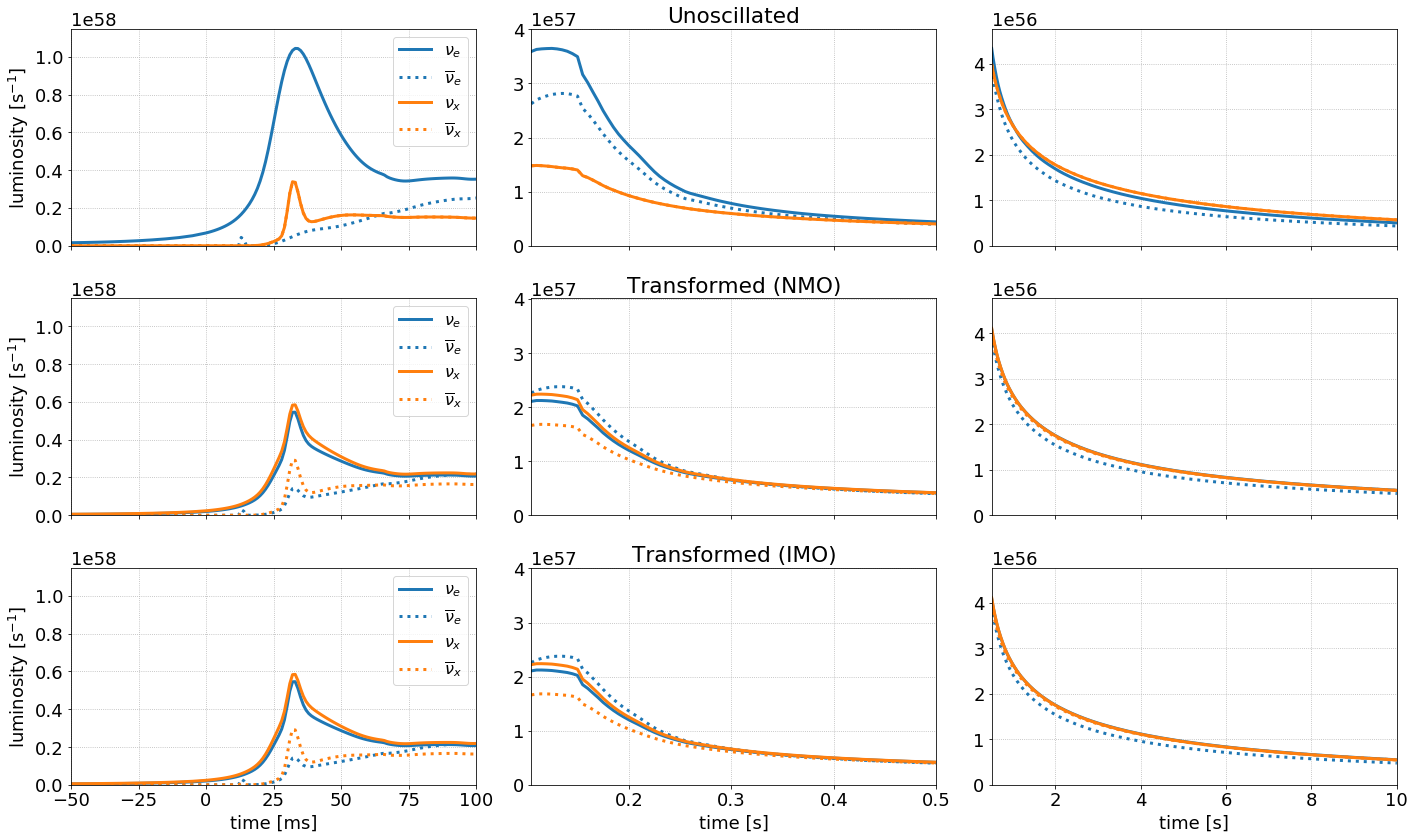

In [12]:
fig = plot_lum(model, NonAdiabaticMSWH, check_imo=True)
fig.savefig('lum_nonadiabaticmswh.pdf')

#### Flux

Convert to flux at Earth, assuming the progenitor distance is 10 kpc.

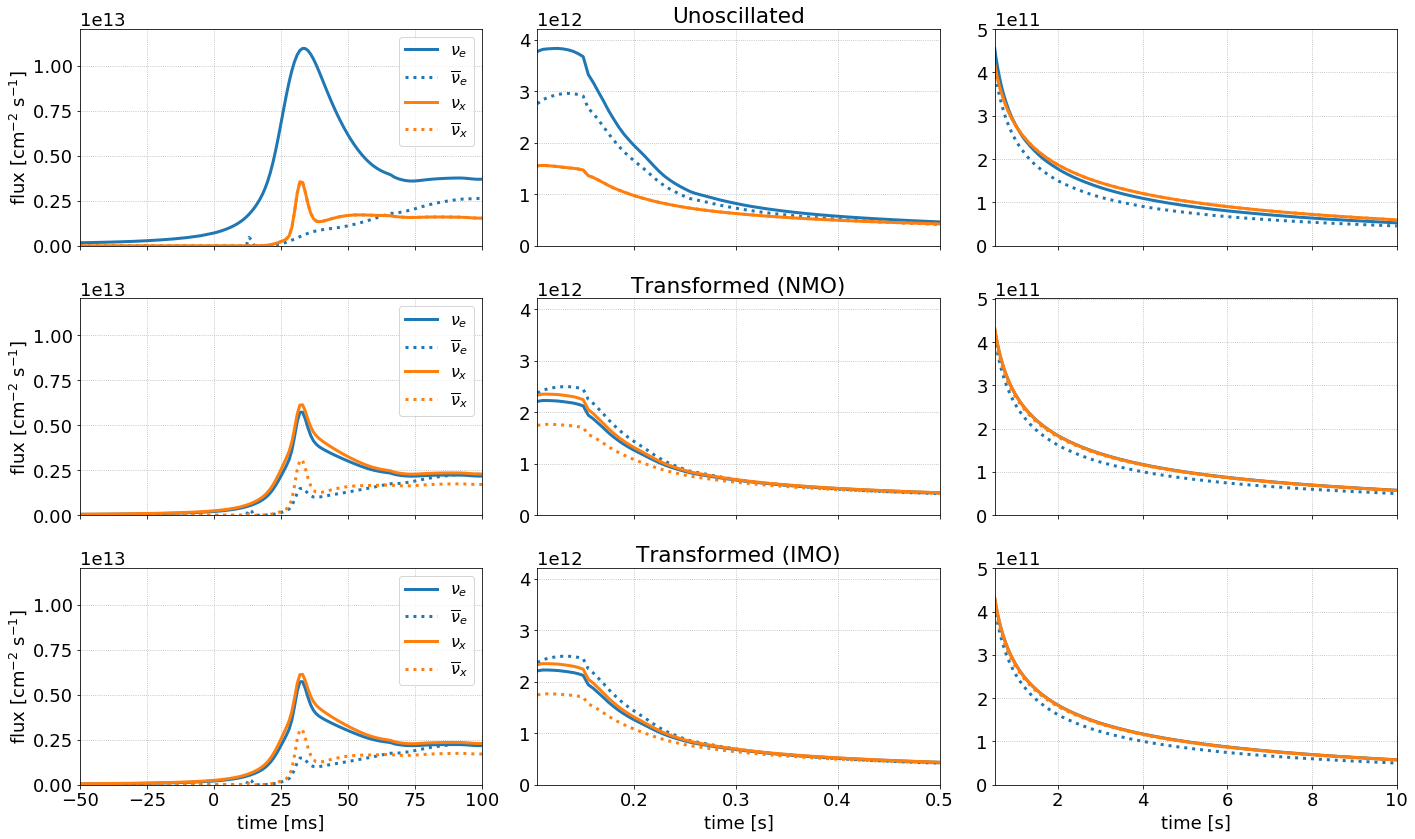

In [13]:
fig = plot_lum(model, NonAdiabaticMSWH, check_imo=True, to_flux=True)
fig.savefig('flux_nonadiabaticmswh.pdf')

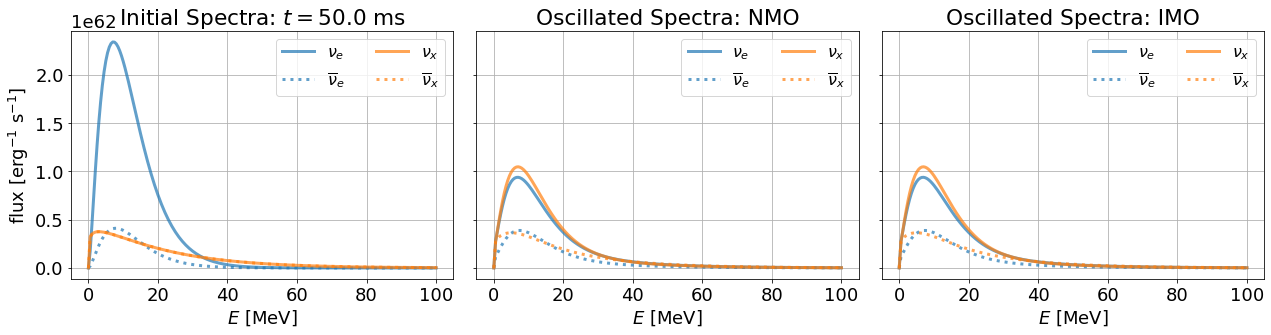

In [14]:
fig = plot_spec(model, NonAdiabaticMSWH)

### `TwoFlavorDecoherence`

#### Luminosity

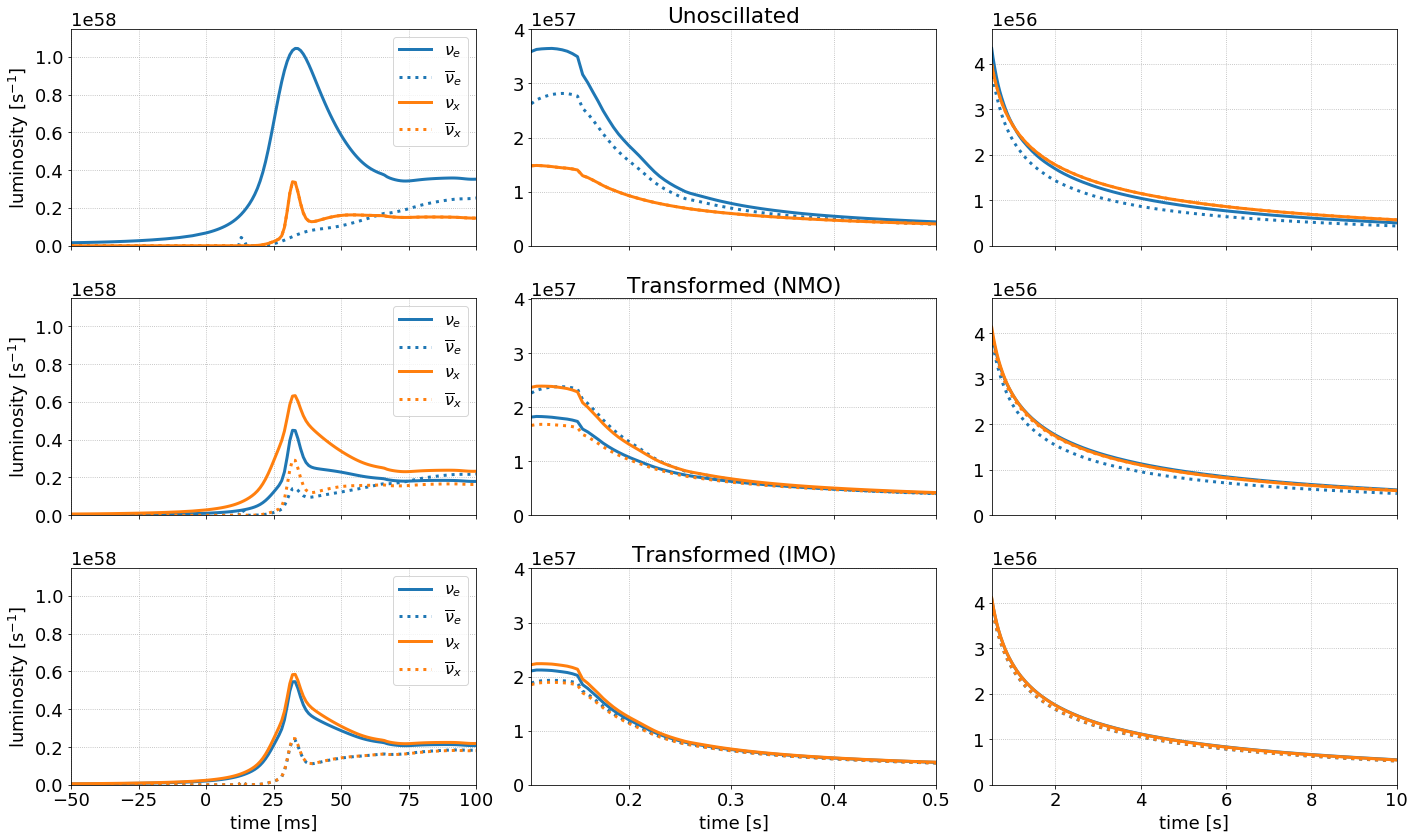

In [15]:
fig = plot_lum(model, TwoFlavorDecoherence, check_imo=True)
fig.savefig('lum_2flavordecoherence.pdf')

#### Flux

Convert to flux at Earth, assuming progenitor distance is 10 kpc.

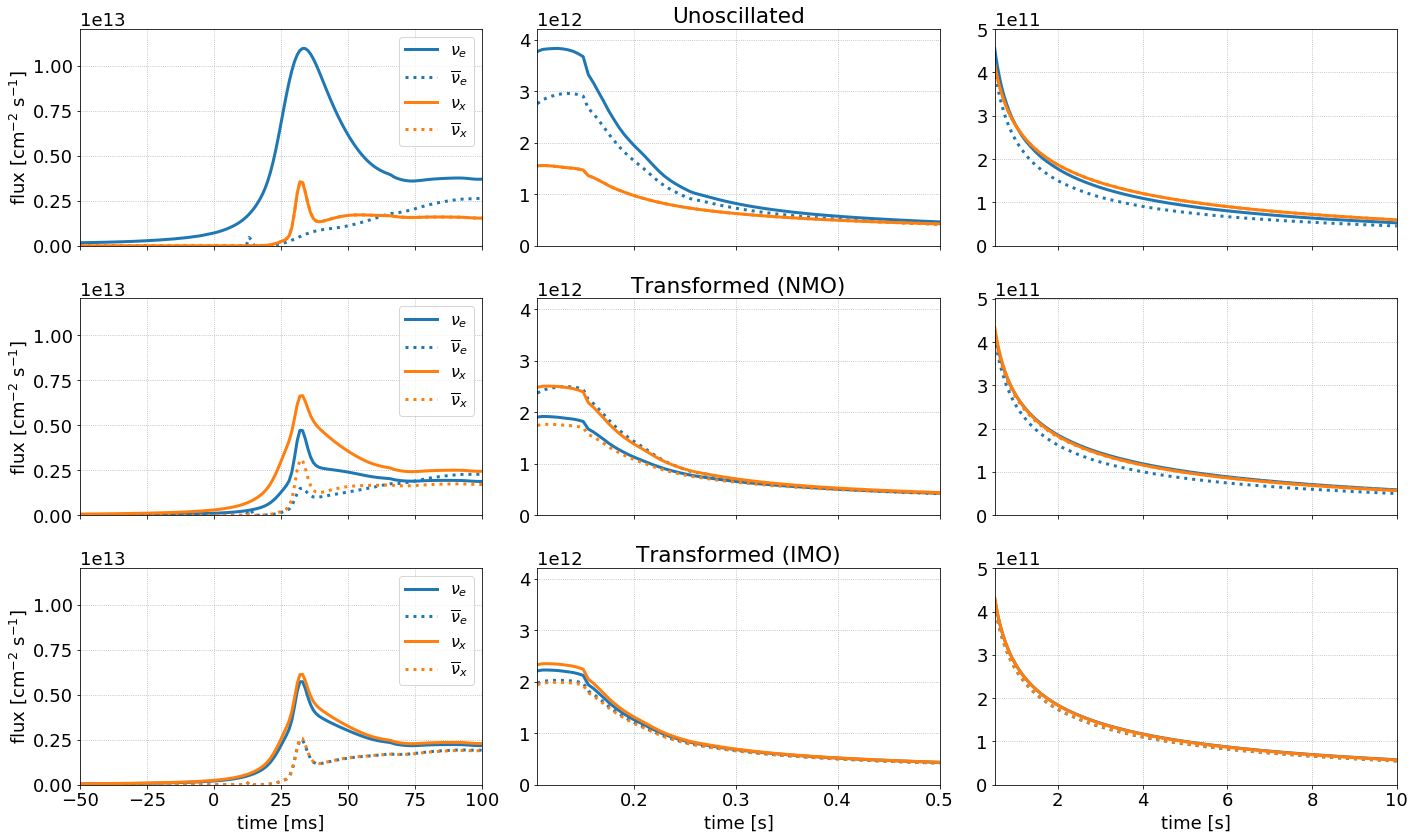

In [16]:
fig = plot_lum(model, TwoFlavorDecoherence, check_imo=True, to_flux=True)
fig.savefig('flux_2flavordecoherence.pdf')

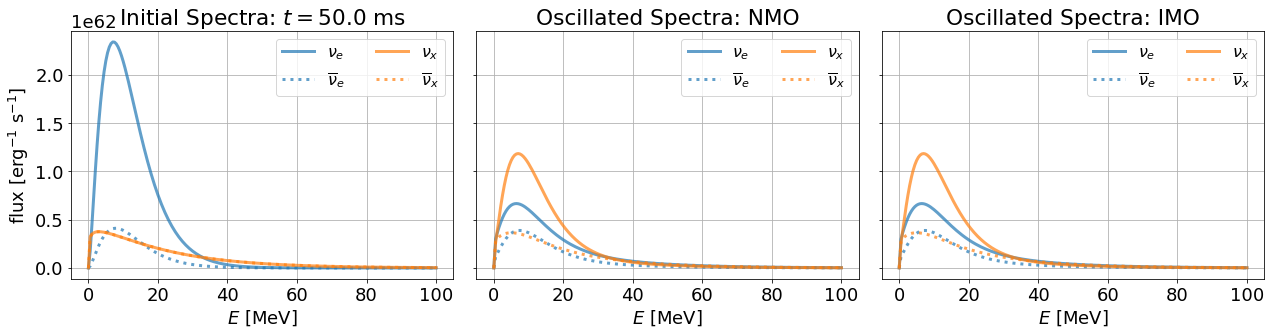

In [17]:
fig = plot_spec(model, TwoFlavorDecoherence)

### `ThreeFlavorDecoherence`

#### Luminosity

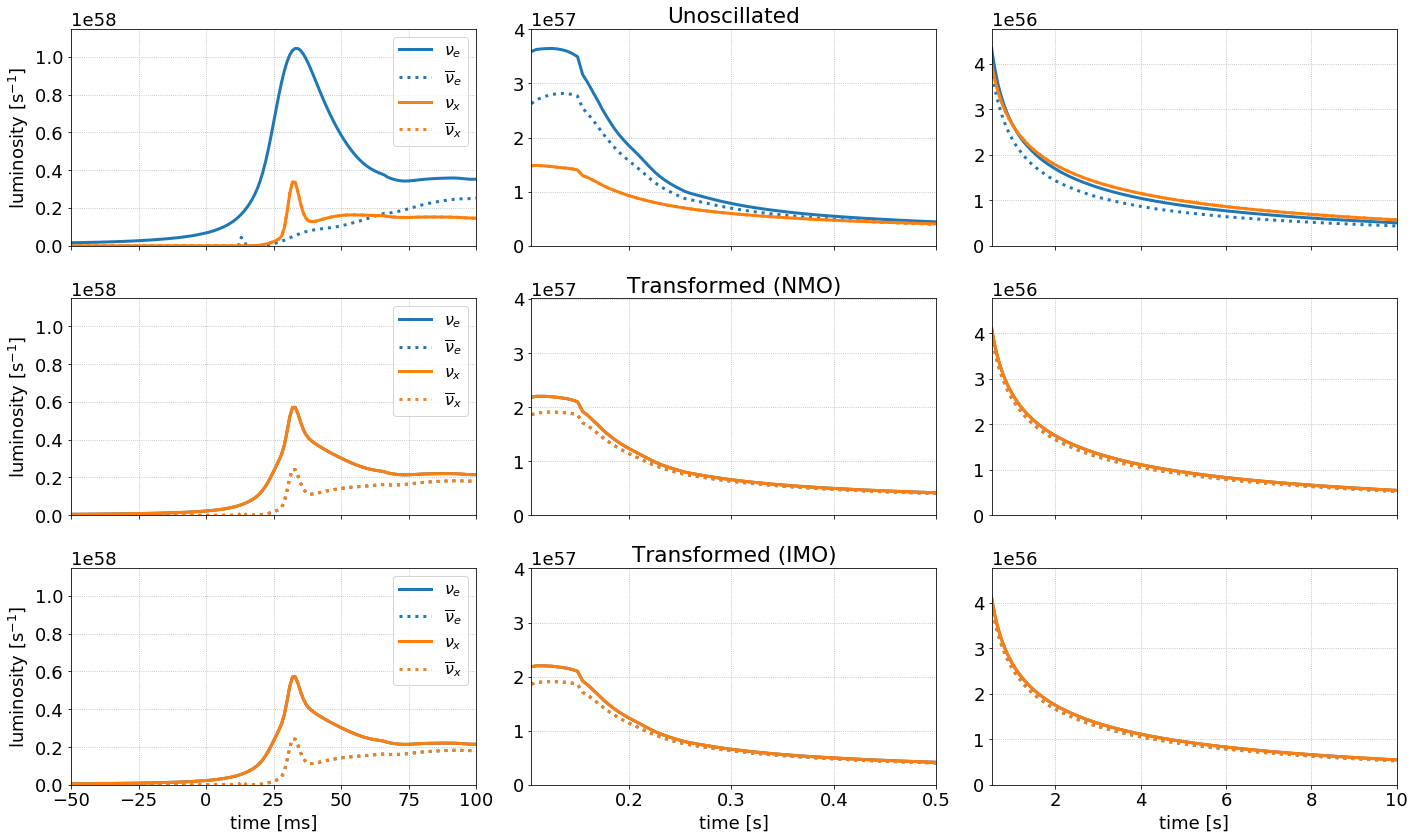

In [18]:
fig = plot_lum(model, ThreeFlavorDecoherence, check_imo=False)
fig.savefig('lum_3flavordecoherence.pdf')

#### Flux

Convert to flux at Earth, assuming the progenitor distance is 10 kpc.

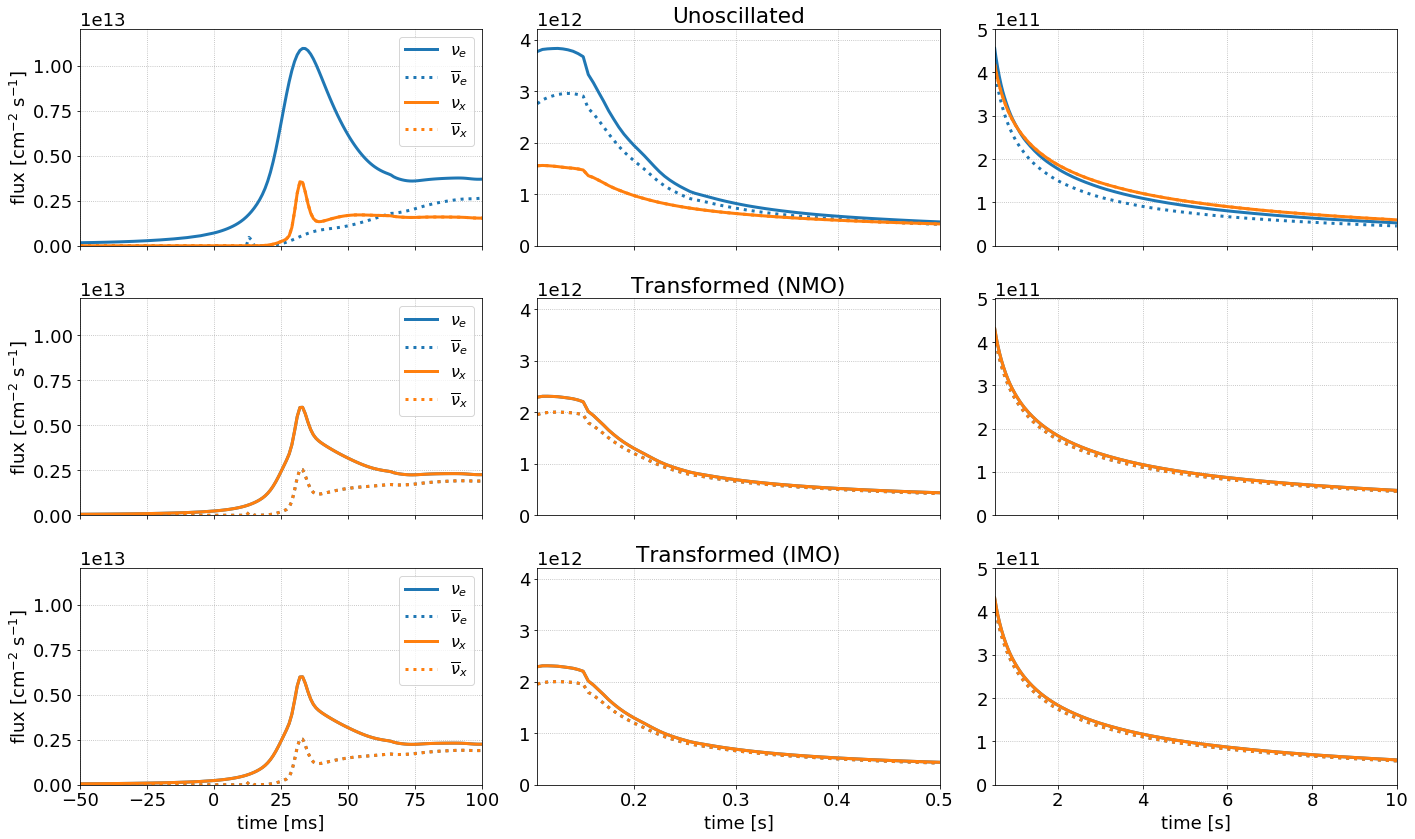

In [19]:
fig = plot_lum(model, ThreeFlavorDecoherence, check_imo=False, to_flux=True)
fig.savefig('flux_3flavordecoherence.pdf')

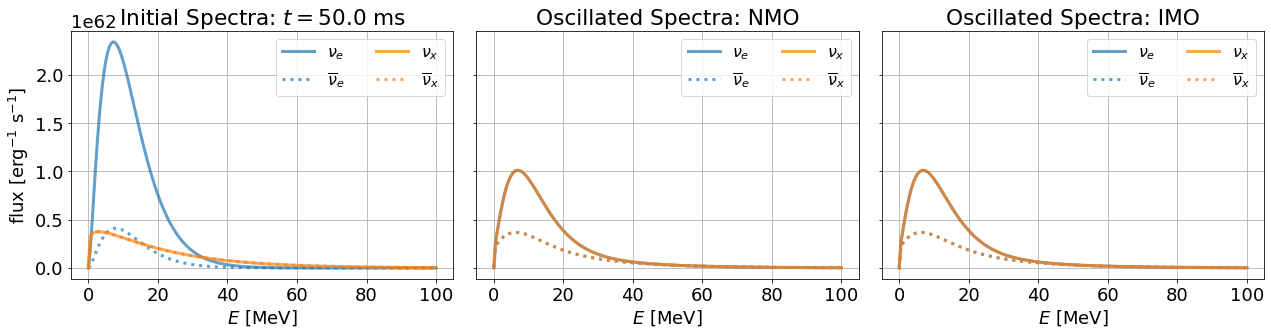

In [20]:
fig = plot_spec(model, ThreeFlavorDecoherence)

### `NeutrinoDecay`

#### Flux

It doesn't make too much sense to plot the neutrino decay spectrum at the source because this is an effect that occurs during transit to Earth. So report the flux only, assuming the progenitor distance is 10 kpc.

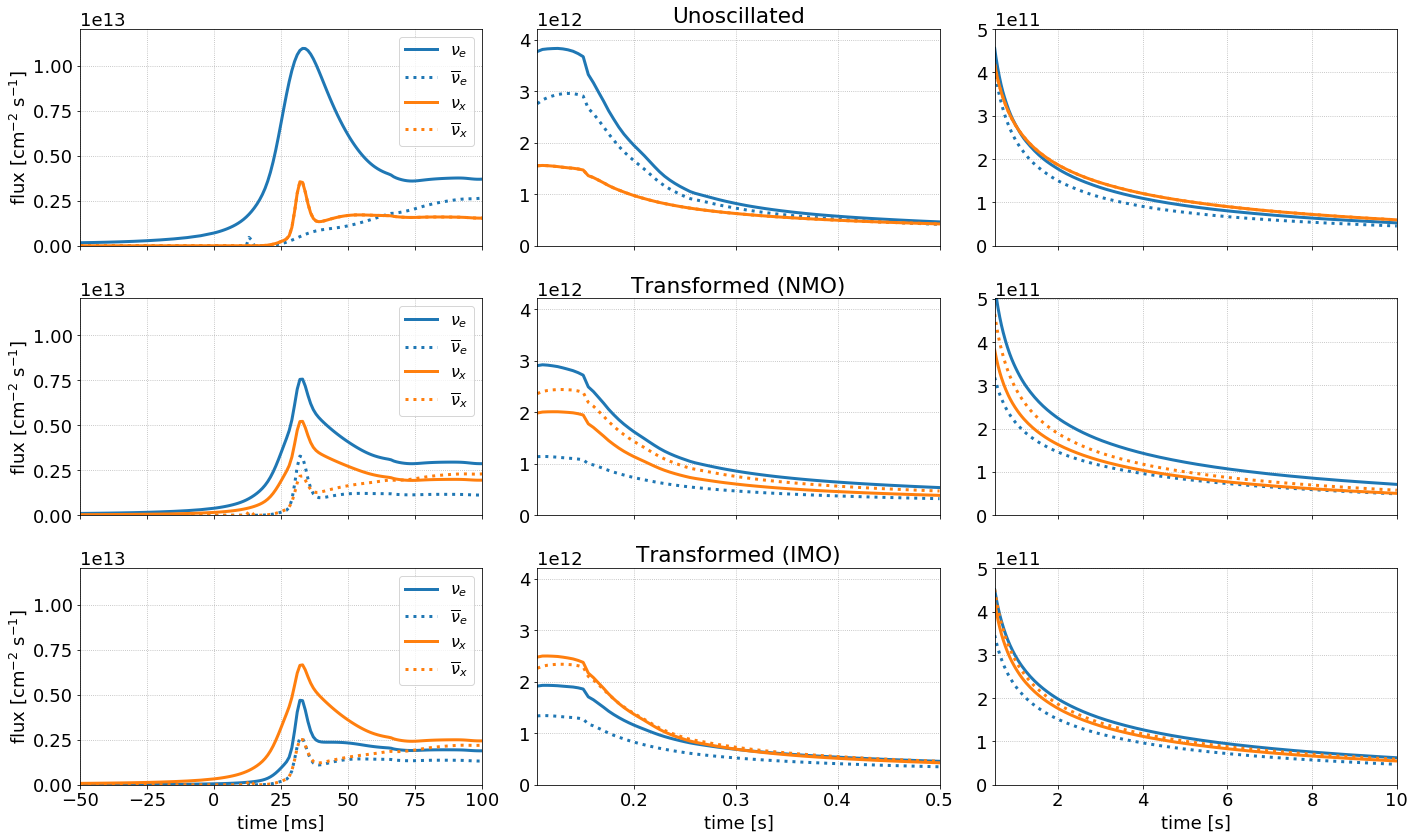

In [21]:
fig = plot_lum(model, NeutrinoDecay, check_imo=True, to_flux=True)
fig.savefig('flux_neutrinodecay.pdf')

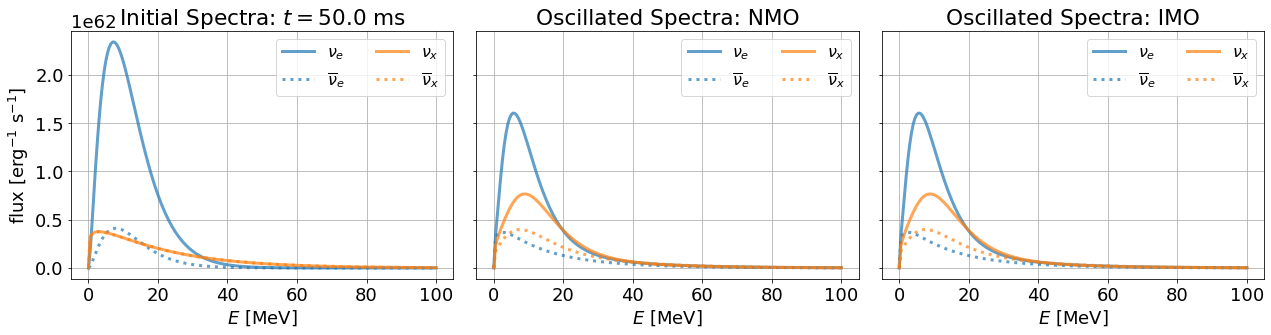

In [22]:
fig = plot_spec(model, NeutrinoDecay)